# Overview, Project Goals and Motivation

The motivation behind this project is to do stuff


## Outline
Part 1 - Data Extraction and Preprocessing <br />
&nbsp;&nbsp;&nbsp;&nbsp; 1.1 - Data Preprocessing <br />
&nbsp;&nbsp;&nbsp;&nbsp; 1.2 - Dataset Visualization <br />
Part 2 - Exploratory Data Analysis <br />
&nbsp;&nbsp;&nbsp;&nbsp; 2.1 - Dominant Color Analysis <br />
&nbsp;&nbsp;&nbsp;&nbsp; 2.2 - Facial Emotion Analysis <br />
&nbsp;&nbsp;&nbsp;&nbsp; 2.3 - Neural Network Prediction <br />
Part 3 - Final Analysis

# Related Work

Article helped with setting up a neural network for multilabeled images <br/>
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/

# Initial Questions


# Part 1 - Data extraction and Preprocessing
Data was extracted through the TMDB API. The code for this is located inside of the scraper.py file on the Github page.
<br/>
At first we downloaded all movie posters possible including movies that were not in english and of any date, but then we decided to narrow down the variables and only accepted movie posters that were made for english speaking movies after the year 2000. We also limited the number of movies in each genre to at most 700 since we did not want a large imbalance in movies

In [9]:
######### IMPORTS ############
#data analysis and vis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

#dominant color imports
from colorthief import ColorThief

#machine learning imports
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing import image
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

#image imports
from PIL import Image 
import cv2

import sys
import os

### Part 1.1 - Data Preprocessing

check csv file and make sure that everything has been properly downloaded

In [14]:
data = pd.read_csv('mov_ids.csv')
data.head()

,Title,Genres,Poster_Path,Language,Release_Date,Popularity,ID,faces
0,"""40 Days and Nights""",Action Science Fiction Adventure Thriller,posters/movie0.png,en,2012-12-15,7.378,145738,1
1,"""Frustration""",Animation,posters/movie1.png,en,2015-03-16,0.600,542615,0
2,"""Tolkien""",Drama History War Romance,posters/movie2.png,en,2019-05-03,23.830,468224,4
3,"""Save Sandra""",Drama,posters/movie3.png,en,2020-10-28,1.172,682270,1
4,"""Nazi Titanic""",TV Movie Documentary,posters/movie4.png,en,2012-04-14,4.412,463397,0


processImages function resizes the posters to 350 pixels by 350 pixels and stores the rgb values into an img_array. This function is specifically used for preprocessing the image for the neural network.

setupData functions takes in the genres from the dataframe and splits them into a binary matrix adding the genres back to the dataframe.

In [15]:
#Folder specification
folder = "posters"

# formatting image dimensions
img_width = 350
img_height = 350
img_count = len([item for item in os.listdir('resized') if os.path.isfile(os.path.join('resized', item))])

def processImages(folder):
    img_array = []

    i = 0
    while i < img_count:
        filename = (folder + "/movie") + str(i) + ".png"
        img = image.load_img(filename, target_size = (img_width, img_height, 3))
        img = image.img_to_array(img) # Converting the image to an array
        img = img / 255.0 # Converting to neural network preferred values
        img_array.append(img)
        i = i + 1
    img_array = np.array(img_array)
    return img_array

def setupData():
    data = pd.read_csv("mov_IDs.csv")
    i = -1  
    
    #setup binary matrix
    for genres in data['Genres']:
        i = i + 1
        genres = genres.split()
        for genre in genres:
            if genre == "TV":
                genre = "TV Movie"
            if genre == "Science":
                genre = "Science Fiction"
            if genre == "Movie" or genre == "Fiction":
                continue
                
            if genre not in data.columns:
                data[genre] = [0 for a in range(0,img_count)]
            data.iloc[i, data.columns.get_loc(genre)] = 1

    dataModel = data.drop(['Title', 'Genres', 'Poster_Path', 'Release_Date', 'Language', 'Popularity', 'ID'], axis = 1)
    dataModel = dataModel.to_numpy()
    img_array = []
    img_array = processImages(folder)
    return data, dataModel, img_array

Resize images to 350 by 350 pixels and put them in their own folder

In [ ]:
res_arr = []
for x in mov_df['Poster_Path']:
    #resize posters
    img = cv2.imread(x) 
    width = 350
    height = 350
    dim = (width, height) 
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    new_path = 'resized/' + x[8:]
    cv2.imwrite(new_path, resized)
    res_arr.append(new_path)

In [16]:
#setup dataframe
mov_df, dataModel, img_array = setupData()

### Part 1.2 - Dataset Visualization
This gives a visualization of what is actually stored in our dataset, primarily the genres and their release dates

Plot of all the genres within our dataset. We tried to limit the number of genres so it could have a more even distribution. In the past 2 decades since 2000, through a random selection of movies, we have found that movie genres related to History, Wars, and Westerns is significantly lower while other movies are more widely produced.

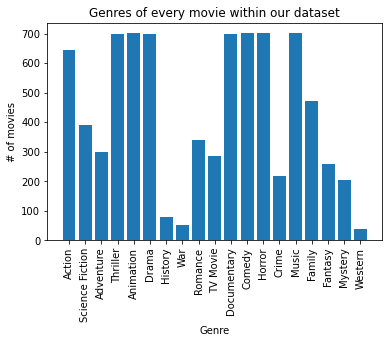

In [5]:
def plotGenre(d):
    data = d.copy()
    
    #read genres from dataframe
    genres = data.columns[7:]
    genreX = []
    genreY = []
    for x in genres:
        genreX.append(x)
        genreY.append(len(data.loc[data[x] == 1]))
    
    #plot genres
    plt.title('Genres of every movie within our dataset')
    plt.xticks(rotation = 90)
    plt.bar(x = genreX, height = genreY)
    plt.xlabel('Genre')
    plt.ylabel('# of movies')
    plt.savefig('charts/genre.png',bbox_inches='tight')
plotGenre(mov_df)

Plot of all release dates within our dataset. <br/>
Although we randomly collected the movie data, with this graph we can see that more and more films have been releasing each year. 

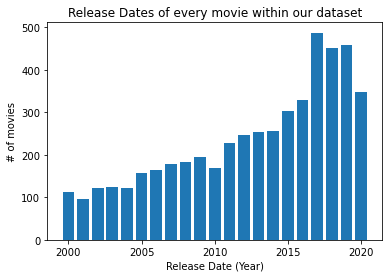

In [6]:
def plotDate(d):
    data = d.copy()
    
    #read dates from dataframe
    dateX = [*range(2000,2021,1)]
    dateY = []
    for x in dateX:
        count = 0
        for y in data['Release_Date']:
            if str(x) == y[0:4]:
                count += 1
        dateY.append(count)
        
    #plot date
    plt.title('Release Dates of every movie within our dataset')
    plt.bar(x = dateX, height = dateY)
    plt.xlabel('Release Date (Year)')
    plt.ylabel('# of movies')
    plt.savefig('charts/dates.png',bbox_inches='tight') 
plotDate(mov_df)

# Part 2 - Exploratory Data Analysis

### Part 2.1 - Dominant Color Extraction
Dominant colors are extracted using the ColorThief tool. It essentially gets the rgb value array of the image and performs kmeans clustering to get the most dominant color. 

First get dominant colors from every poster and store it inside of the dataframe

In [7]:
domcol = []
for x in res_arr:
    #get dominant colors and palette
    color_thief = ColorThief(new_path)
    dominant_color = color_thief.get_color(quality=1)
    domcol.append(dominant_color)
mov_df['dominant_color'] = domcol

Ready average dominant color for single genres to be graphed

In [70]:
gen_col = []
yarr = []
for x in mov_df.columns[7:-2]:
    temp = mov_df.loc[mov_df[x] == 1]

    arr = temp['dominant_color'].to_numpy()
    yarr.append(len(arr))
    rgb = []
    rsum = 0
    gsum = 0
    bsum = 0
    for y in arr:
        rsum += y[0]
        gsum += y[1]
        bsum += y[2]
    rsum = rsum / len(arr)
    gsum = gsum / len(arr)
    bsum = bsum / len(arr)
    rgb.append(rsum /255)
    rgb.append(gsum /255)
    rgb.append(bsum /255)
    gen_col.append(rgb)

#### Graph of Dominant Color for single genres. 
The average dominant color of each genre is a brown color with lighter shades in some genres. This may mean that there is little overall relation between dominant color and genre because they converge to a brown color when mixed together and averaged. 

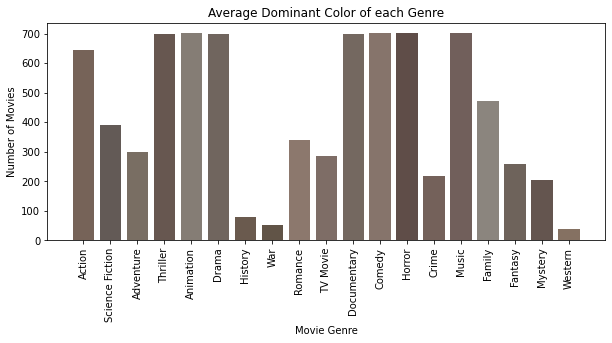

In [75]:
fig = plt.subplots(figsize = (10,4))
xarr = mov_df.columns[7:-2]

plt.bar(xarr,yarr,color=gen_col)
plt.xlabel('Movie Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.title('Average Dominant Color of each Genre')
plt.savefig('dom_color.png',bbox_inches='tight')

Ready average dominant colors for paired genres since each movie may have more than one genre describing it.

In [73]:
g_arr = mov_df.columns[7:-2].to_numpy()
Xmulti = []
Cmulti = []
Ymulti = []
for x in mov_df.columns[7:-2]:
    for y in g_arr:
        if (x != y) & len(mov_df.loc[(mov_df[x] == 1) & (mov_df[y] == 1)]) > 0 :
            temp = mov_df.loc[(mov_df[x] == 1) & (mov_df[y] == 1)]
            Xmulti.append(x + ' ' + y)
            
            arr = temp['dominant_color'].to_numpy()
            rgb = []
            rsum = 0
            gsum = 0
            bsum = 0
            for y in arr:
                rsum += y[0]
                gsum += y[1]
                bsum += y[2]
            rsum = rsum / len(arr)
            gsum = gsum / len(arr)
            bsum = bsum / len(arr)
            rgb.append(rsum /255)
            rgb.append(gsum /255)
            rgb.append(bsum /255)
            Cmulti.append(rgb)
            Ymulti.append(len(temp))
    g_arr = np.delete(g_arr,0)

#### Graph of average dominant color for paired genres 
Each genre can be paired and the average dominant color can be seen. The only significant changes that deviate from primarily brown are in genres of movies that are less than 30. Otherwise the average dominant color is either a brownish color or a greyish color.

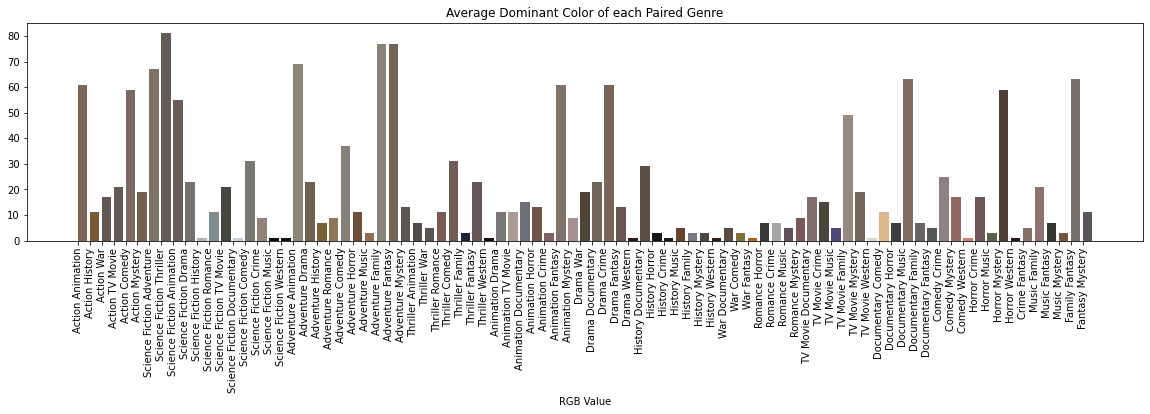

In [74]:
fig = plt.subplots(figsize = (20,4))

plt.bar(Xmulti,Ymulti,color=Cmulti, align = 'edge')
plt.xlabel('Movie Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.title('Average Dominant Color of each Paired Genre')
plt.savefig('dom_color.png',bbox_inches='tight')

### Part 2.2 - Facial Recognition and Poster 

We can use python's face_recognition library in order to detect faces in our movie posters. The face recognition is not perfect (many movie posters have artistically distorted faces which are hard to register) and the module we are using is likely trained on real world images.

In [ ]:
import face_recognition
import pandas as pd
import os
import numpy as np

csv_input = pd.read_csv('mov_IDs.csv')
faces = []
for entry in os.scandir("posters"):
    if (entry.path.endswith(".jpg")
            or entry.path.endswith(".png")) and entry.is_file():
        image = face_recognition.load_image_file(entry.path)
        face_locations = face_recognition.face_locations(image)
        print(len(face_locations))
        faces.append(len(face_locations))



In [5]:
csv_input['faces'] = np.array(faces)
csv_input.to_csv('mov_IDs_faces.csv', index=False)


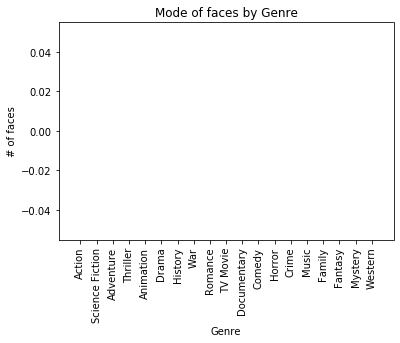

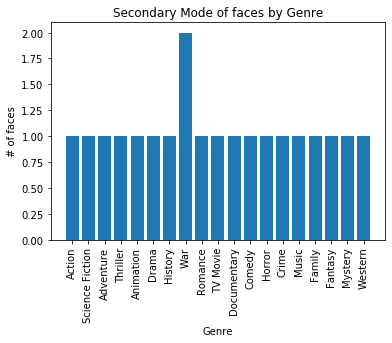

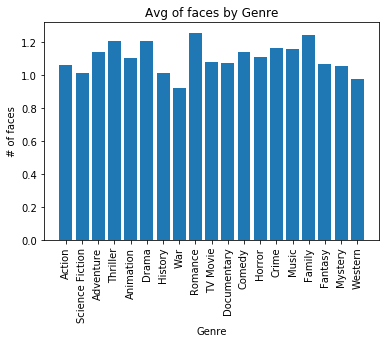

In [83]:
import statistics
from statistics import mean
def plotFace(d):
    data = d.copy()
    genres = data.columns[8:]
    amt = []
    for x in genres:
        amt.append(len(data.loc[data[x] == 1]))
    genre_mode = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    secondary_mode = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    genre_avg = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    count = 0
    genre_list = [[] for i in range(19)]
    for index, row in data.iterrows():
        count = 0
        for genre in genres:
            if row[genre]==1:
                genre_list[count].append(row['faces'])
            count += 1
    idx = 0

    for mode, lst in zip(genre_mode, genre_list):
        arr = np.array(lst)
        mode = statistics.mode(arr)
        genre_mode[idx] = mode
        idx+=1
    idx = 0
    plt.title('Mode of faces by Genre')
    plt.xticks(rotation = 90)
    plt.bar(x = genres, height = genre_mode)
    plt.xlabel('Genre')
    plt.ylabel('# of faces')
    plt.savefig('mode_faces.png',bbox_inches='tight')
    plt.show()

    for mode, lst in zip(secondary_mode, genre_list):
        arr = np.array(lst)
        non_zero = arr[np.nonzero(arr)]
        mode = statistics.mode(non_zero)
        secondary_mode[idx] = mode
        idx+=1

    plt.title('Secondary Mode of faces by Genre')
    plt.xticks(rotation = 90)
    plt.bar(x = genres, height = secondary_mode)
    plt.xlabel('Genre')
    plt.ylabel('# of faces')
    plt.savefig('secondary_mode_faces.png',bbox_inches='tight')
    plt.show()
    idx = 0


    for avg, lst in zip(genre_avg, genre_list):
        avg = sum(lst)/ float(len(lst))
        genre_avg[idx] = avg
        idx+=1
        
    plt.title('Avg of faces by Genre')
    plt.xticks(rotation = 90)
    plt.bar(x = genres, height = genre_avg)
    plt.xlabel('Genre')
    plt.ylabel('# of faces')
    plt.savefig('avg_faces.png',bbox_inches='tight')

plotFace(mov_df)

According to the facial recognition algorithim, the mode of faces for all genres was 0, while the secondary mode was 1. The averages for all the genres hovered around 1. Although this seems somewhat with a cursory glance of the posters folder, we are curious to see if a more robust face detection algorithim that was trained on movie posters rather than regular pictures could do a better job and reveal different results. One facial recognition service we tried that performed slightly better was Azure's Face API but due to cost and rate limits it was infeasible to run it multiple times. We could also train our own facial detection algorithim on movie posters but A) There is no labeled data and B) This was not the focus of our project.

### Part 2.3 - Convolutional Neural Network

This prediction of genres of a movie based off of other movie posters is a multi-label classification problem. We are trying to assign multiple labels to a poster rather than just one label. Neural networks can be configured to support multi-label classification and can predict well. This is why we have chosen a neural network to make our prediction model. Every node in the neural network uses sigmoid activation and the neural network is fit with the binary cross entropy loss function. More information about the sequential model and its applications can be found here: https://keras.io/guides/sequential_model/

This function sets up the neural network, and creates a sequential prediction model. The model is trained on the processed images above. A summary of the model and its layers is then printed along with plots showing the accuracy of the model evaluated against test data generated by the test_train_split function from sklearn. Finally, the setUpNeuralNetwork function returns the trained model.

In [ ]:
def setupNeuralNetwork(dataModel, img_array):
    X_train, X_test, y_train, y_test = train_test_split(img_array, dataModel, random_state = 0, test_size = 0.15)
    print(X_train.shape)

    #Build sequential CNN
    model = Sequential()

    #Configure convolutional layers, specify filter and activation function
    model.add(Conv2D(16, (3,3), activation='relu', input_shape = X_train[0].shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(len(data.columns) - 7, activation='sigmoid'))
    print(model.summary())
    #print("train:", X_train.shape)
    #print("test:", X_test.shape)

    # Compile and fit the model. Validation data is the data used to evaluate the accuracy of our model
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
    #Epochs is the number of times we want to pass the training data through the network.
    history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
    plot_learningCurve(history, 5)
    return model


def plot_learningCurve(history, epoch):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

The predictGenre function uses the prediction model to predict the genres of the movie given as the input. predict() returns the probabilities for each genre of the movie poster belonging to that genre. The predictGenre function then prints out the 3 genres with the highest probability values.

In [ ]:
def predictGenre(model, img):
    # load weights into new model
    print("Loaded model from disk")
    img = image.load_img(img, target_size = (img_width, img_height, 3))
    plt.imshow(img)
    img = image.img_to_array(img)
    img = img/255.0
    img = img.reshape(1, img_width, img_height, 3)

    genres = data.columns[7:]
    print(genres)
    probGenres = model.predict(img)
    print(probGenres[0])
    print(np.argsort(probGenres[0]))
    top3Genres = np.argsort(probGenres[0])[:-4:-1]
    print(probGenres[0][top3Genres])

    for i in range(3):
            print(genres[top3Genres[i]])

Warning: We don't recommend running the next block of code since it may take hours depending on your computer to create a model from scratch. The trained model has already been saved in a folder and can be loaded to make our predictions. It's summary has also been printed above.

In [ ]:
data, dataModel, img_array = setupData()
model = setupNeuralNetwork(dataModel, img_array)
model.save("savedModel")
print("Model has been saved")

# Part 3 - Final Analysis